In [2]:
# Ставим необходимые пакеты
!pip install catboost #Пакет градиентного бустинга от Яндекса. Использован в качестве базовой модели
!pip install ipywidgets # этот и следующий нужны для нормального отображения гарфики в Colab
!jupyter nbextension enable --py widgetsnbextension

!pip install sweetviz #Крутой пакет анализа Датасета в одну строчку кода
#!pip install -U geometric-smote #пробуем балансировать cv_dataset
!pip install shap #Пакет интерпритации весов модели для определения значимости признаков
#!pip install smogn # Аугментация для несбалансированных датасетов у меня не заработала
#!pip install git+https://github.com/nickkunz/smogn.git
!git clone --recursive https://github.com/convergence-lab/SMOGN.git


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.3 MB/s eta 0:00:00
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 4.8 MB/s eta 0:00:00
Cloning into 'SMOGN'...
remote: Enumerating objects: 230, done.
remote: Counting objects: 100% (230/230), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 230 (delta 106), reused 173 (delta 56), pack-reused 0
Receiving objects: 100% (230/230), 5.69 MiB | 10.71 MiB/s, done.
Resolving deltas: 100% (106/106), done.
Submodule 'Imbalanced-Regression-DataSet

In [3]:
# Хороший AutoMl для регрессии
!pip  install tpot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.4/87.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11938 sha256=6dfc9d16e702cfe0382e2aadb955aef415101e5d739140a59322351f958cc88a
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit


In [4]:
# Еще один AutoML
!pip install flaml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.1 MB/s eta 0:00:00


In [5]:
from google.colab import output
output.enable_custom_widget_manager()

In [6]:
#@title Импортируем Библиотеки
import os

import numpy as np
import pandas as pd
from pandas.io.formats.format import NA

import catboost as cb

from sklearn.metrics import classification_report, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import shap
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
import matplotlib.animation as animation
import seaborn as sns

import sweetviz as sw
%matplotlib inline

#from gsmote import GeometricSMOTE

# очистка ОЗУ
import gc

import warnings
warnings.filterwarnings('ignore')

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [7]:
#@title Монтируем Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
#@title Очистка и анализ данных
PATH = '/content/drive/MyDrive/Warfarin/'
fname = PATH+'dataForAll.xlsx'  #Файл Сергея
df = pd.read_excel(fname)
df.Diag = df.Diag.astype('category') #Диагнозыы и сердечно-сосудистые события
df.sss = df.sss.astype('category')    # превращаем в категориальные данные
 # !!! Важно для правильного вычисления разностных данных сортируем данные по пациенту
 # и дате анализа
df.sort_values(by=['IndPats', 'AnalisDate'], inplace=True)
#Конструируем дифференцаальные признаки
sample =1
df['Sample'] = 1
df['Prev_MG'] = np.nan
df['prev_MNO'] = np.nan
df['date_diff'] = 0
print(f'{fname}:{df.shape[0]} записей')
for i in range(1,df.shape[0]):
  if df.IndPats.iloc[i] == df.IndPats.iloc[i-1]:
    sample +=1
    df['Prev_MG'].iloc[i] = df.mg.iloc[i-1]
    df['prev_MNO'].iloc[i] = df.MNO.iloc[i-1]
    df['date_diff'].iloc[i] = (df.AnalisDate.iloc[i]-df.AnalisDate.iloc[i-1]).days
  else:
    sample = 1
  df['Sample'].iloc[i] = sample
  len = df.shape[0]
test_len = round(len * .2)
# Убираем выбросы
df.reset_index()
df = df[np.abs(df.age-df.age.mean()) <= (3*df.age.std())]
df = df[np.abs(df.MNO-df.MNO.mean()) <= (3*df.MNO.std())]
# Парсим категории
df.Diag = df.Diag.astype('category')
df.sss = df.sss.astype('category')

df = pd.get_dummies(df, prefix=['Diag','sss'])
# разбираем парные диагнозы на еденичные
df.Diag_1.loc[(df['Diag_7']==1)
              |(df['Diag_9']==1)
              |(df['Diag_11']==1)] = 1 #Парсим ФП
df.Diag_2.loc[(df['Diag_7']==1)
              |(df['Diag_8']==1)
              |(df['Diag_10']==1)
              |(df['Diag_12']==1)
              |(df['Diag_14']==1)] =1  #Парсим ПС
df.Diag_3.loc[(df['Diag_8']==1)
              |(df['Diag_9']==1)
              |(df['Diag_11']==1)] = 1 #Парсим ИБС
df.Diag_4.loc[df['Diag_10']==1] = 1 #Парсим ИБС
df.Diag_6.loc[(df['Diag_12']==1)
              |(df['Diag_13']==1)
              |(df['Diag_14']==1)] = 1 #Парсим Ревм
# Теперь сердечно-сосудистые события
df.sss_3.loc[(df['sss_10']==1)] = 1   #Парсим Кс
df.sss_4.loc[(df['sss_9']==1)
              |(df['sss_11']==1)
              |(df['sss_13']==1)] = 1 #Парсим ПК
df.sss_5.loc[(df['sss_9']==1)
              |(df['sss_10']==1)
              |(df['sss_12']==1)
              |(df['sss_13']==1)] = 1 #Парсим КШ
df.sss_6.loc[(df['sss_11']==1)] = 1   #Парсим СТ
# Убираем лишнее
df.drop(columns =  ['Diag_7','Diag_8','Diag_9','Diag_10','Diag_11','Diag_12','Diag_13','Diag_14'],inplace=True)
df.drop(columns =  ['sss_1','sss_10','sss_11','sss_12','sss_13'],inplace=True)
#df = pd.concat([df,pd.get_dummies(df, columns=['sss'], prefix='sss')])

#превращаем возраст в AGE_RANGE равные возрастные группы
AGE_RANGE = 3
range_list = np.linspace(0, 1, AGE_RANGE+1, endpoint=0)
range_list = range_list[1:]
age_q = df.age.quantile(range_list).to_numpy()
df['age'+f'{int(age_q[0])}'] = (df.age < age_q[0]).astype(int) # First Value
for i in range(1,AGE_RANGE-1):
  df['age'+f'{int(age_q[i])}'] = ((df.age >= age_q[i]) & (df.age <age_q[i+1])).astype(int)
df['age'+f'{int(age_q[AGE_RANGE-1])}'] = (df.age >= age_q[AGE_RANGE-1]).astype(int) # LAST Value
#print(f'{[(range_list[i],age_q[i]) for i in range(AGE_RANGE)]}')
df.drop(columns='AnalisDate',inplace=True)
# Пишем Файл
df.reset_index()
with pd.ExcelWriter(fname[:-5]+'_dif.xlsx') as writer:
  df.to_excel(writer, sheet_name="Sheet1",index=False)


/content/drive/MyDrive/Warfarin/dataForAll.xlsx:1917 записей


                                             |          | [  0%]   00:00 -> (? left)


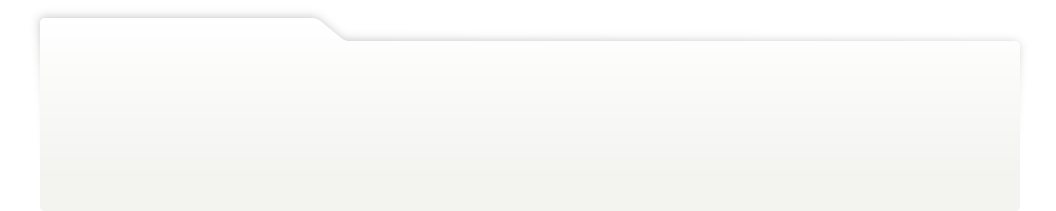
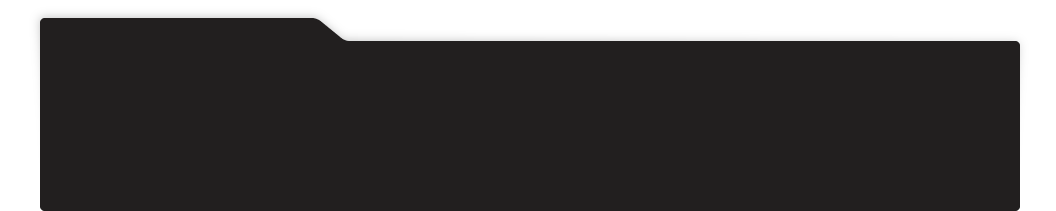
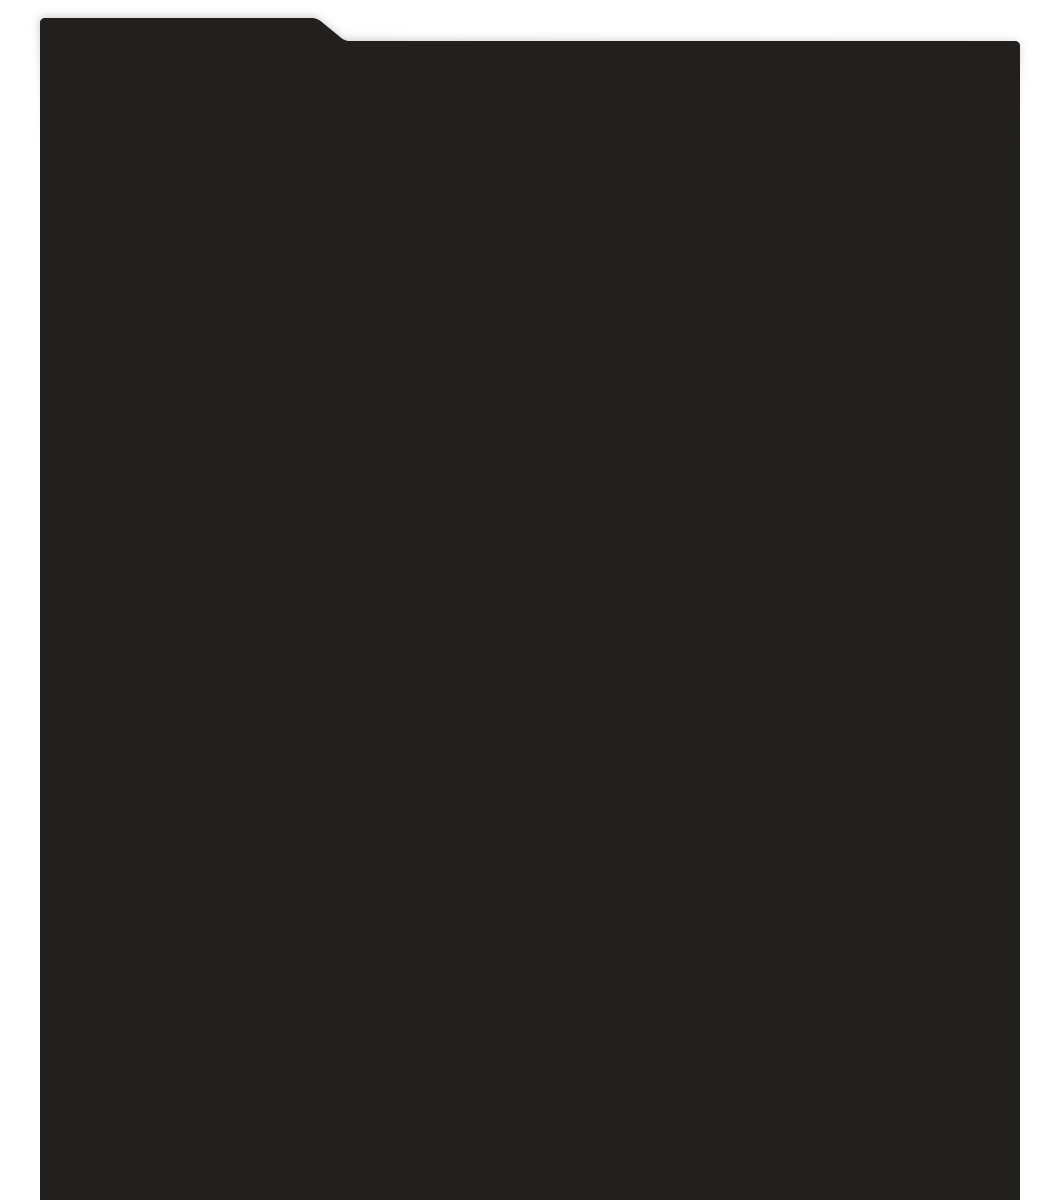
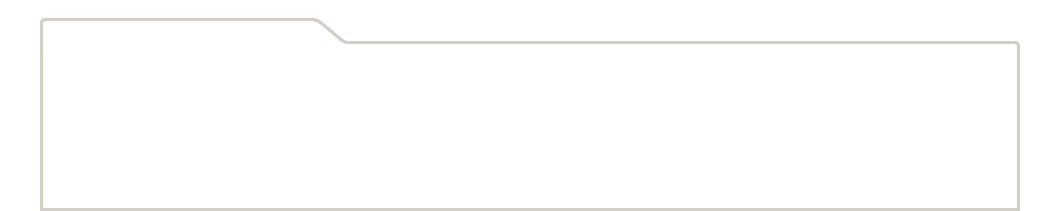
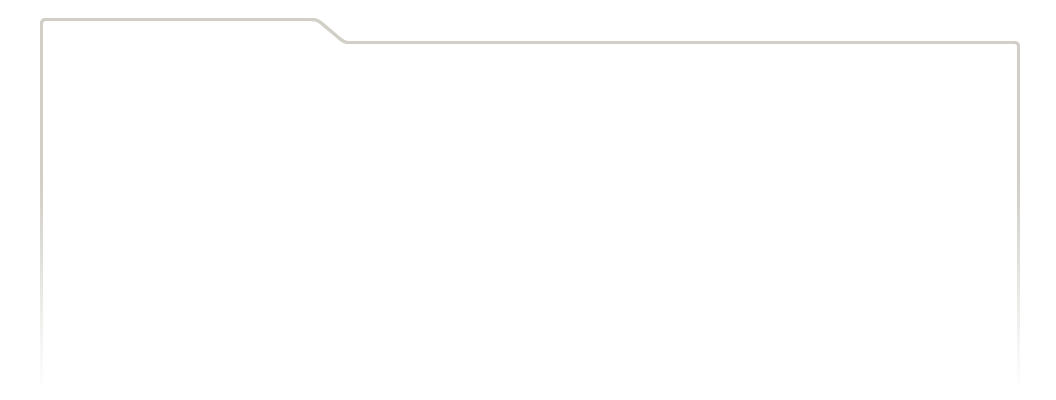
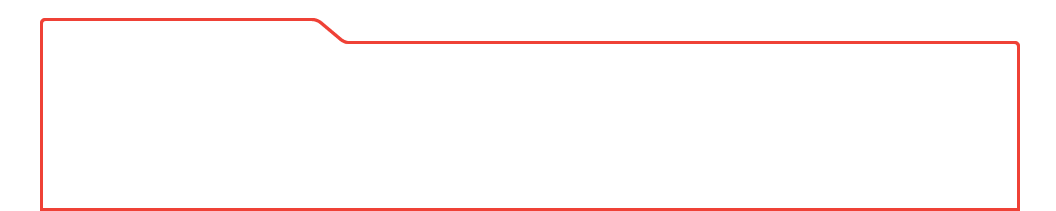
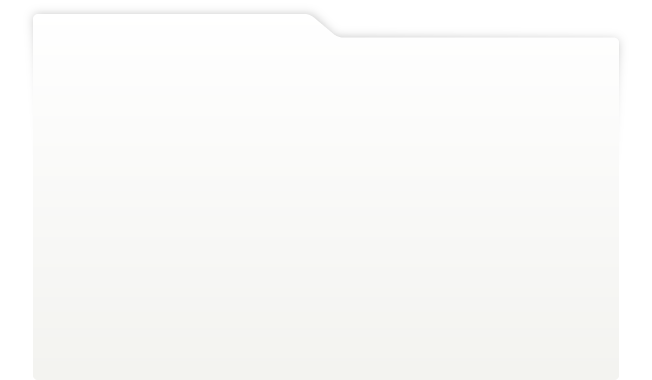
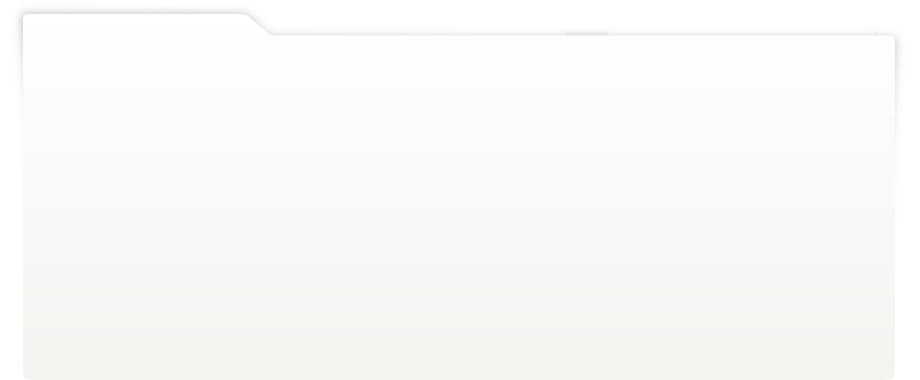
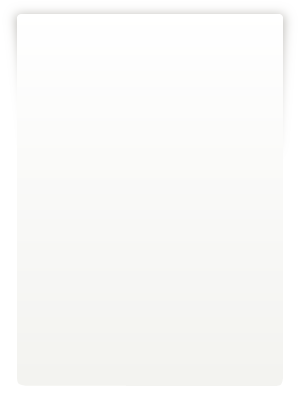
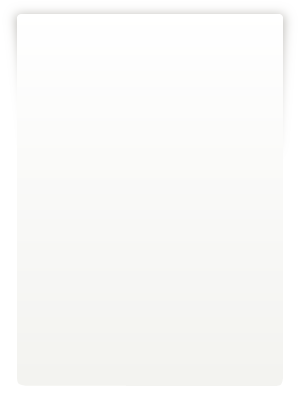
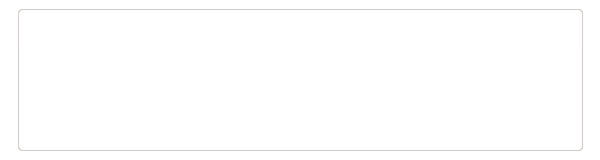
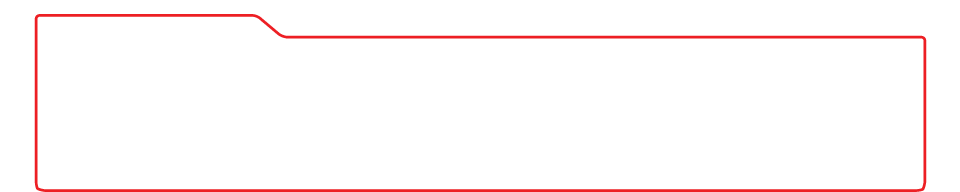
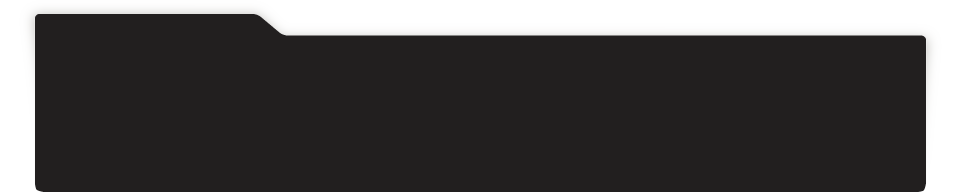
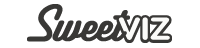
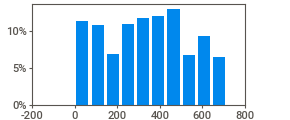
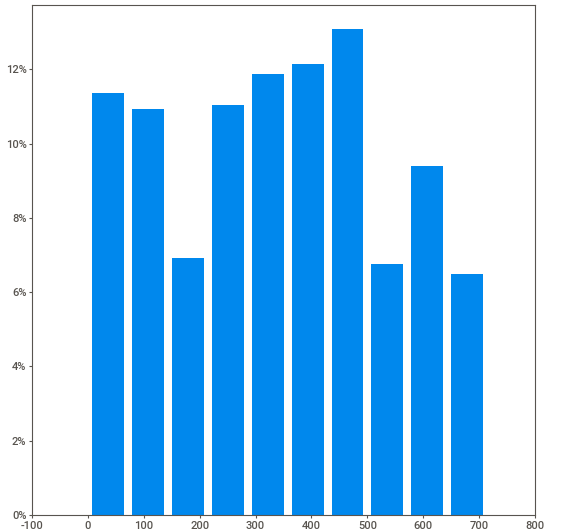
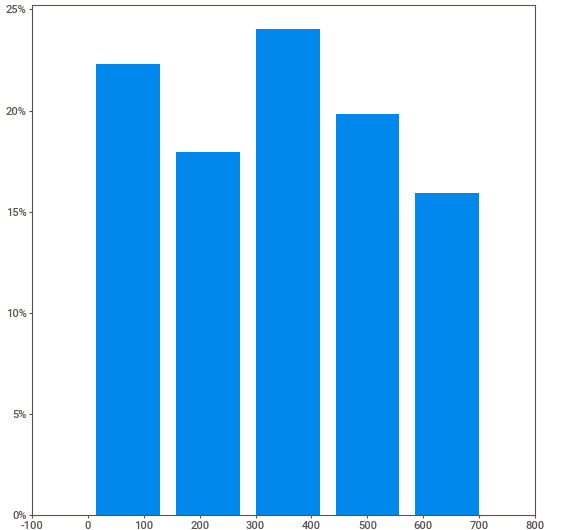
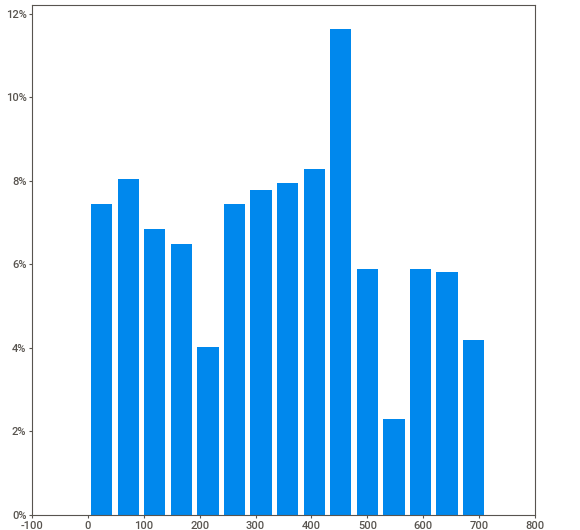
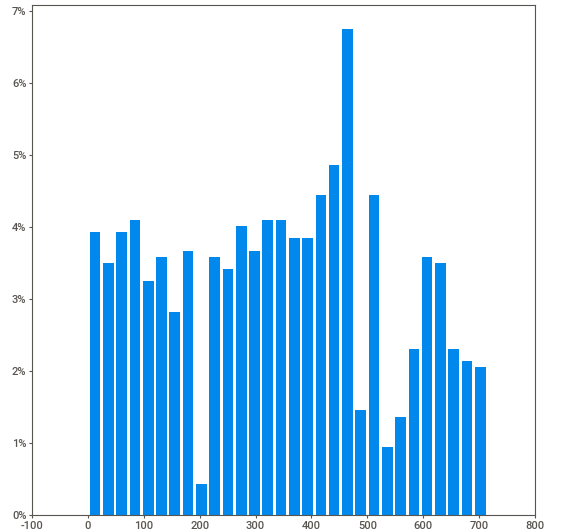
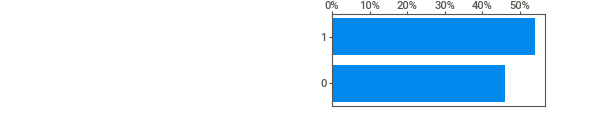
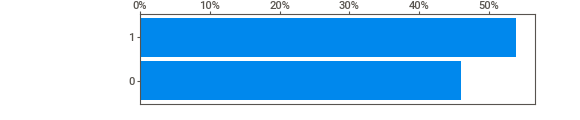
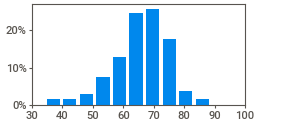
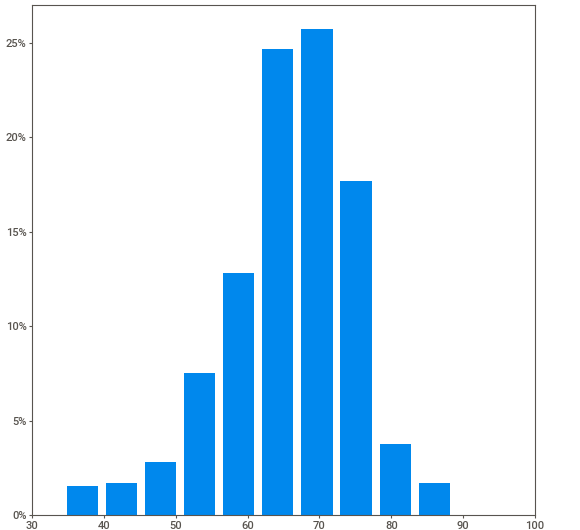
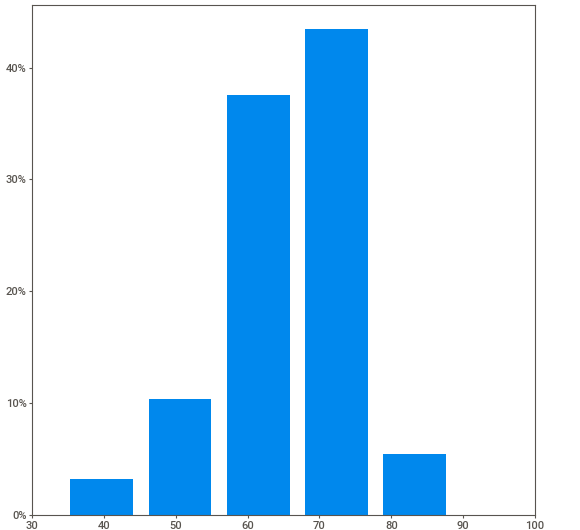
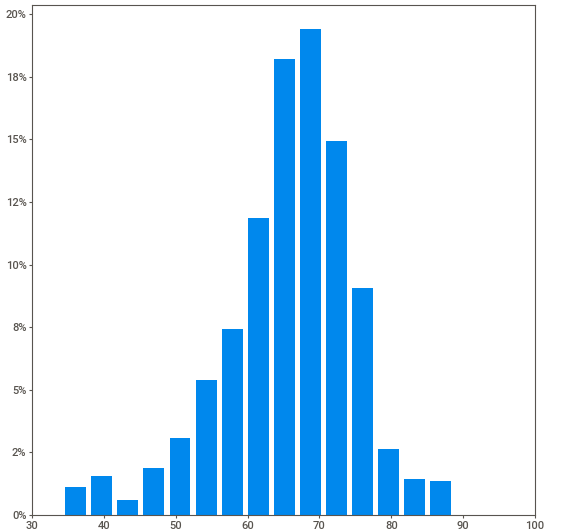
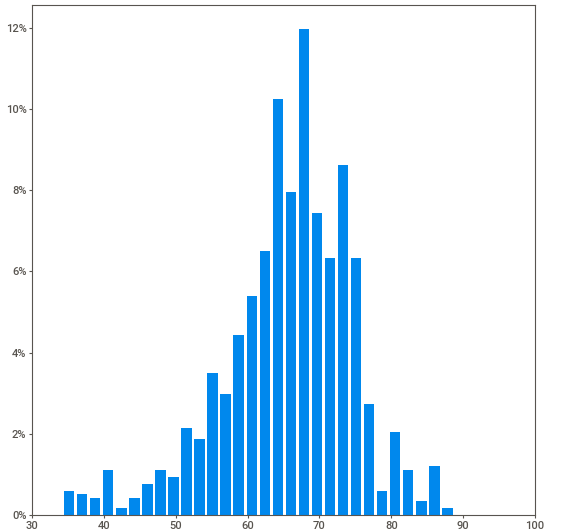
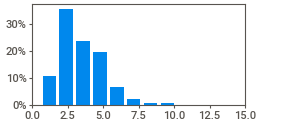
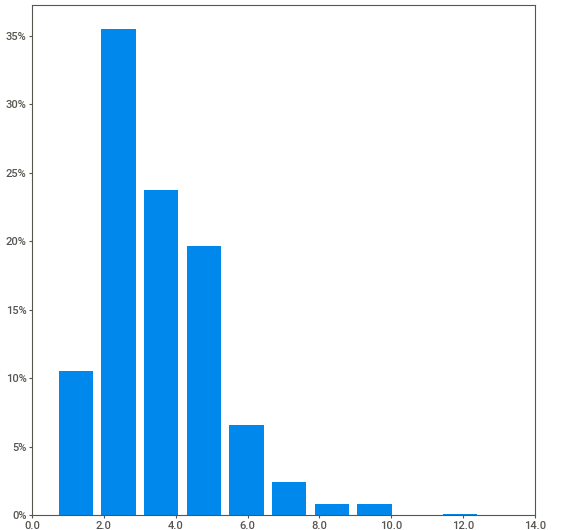
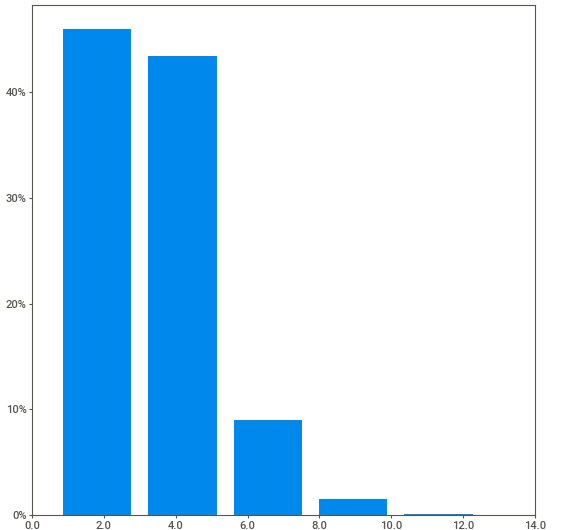
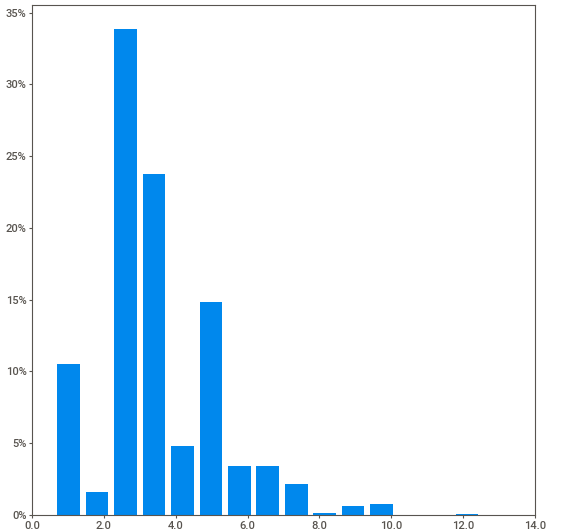
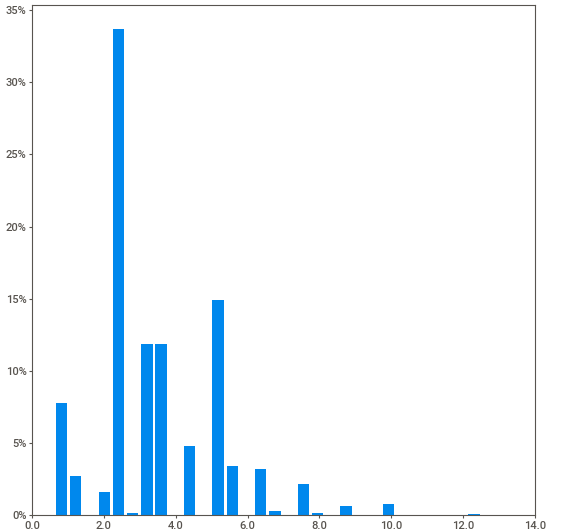
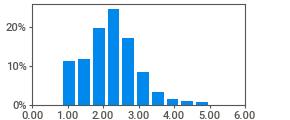
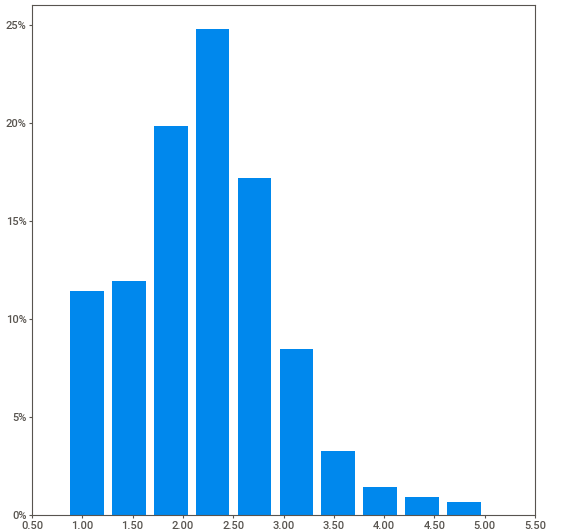
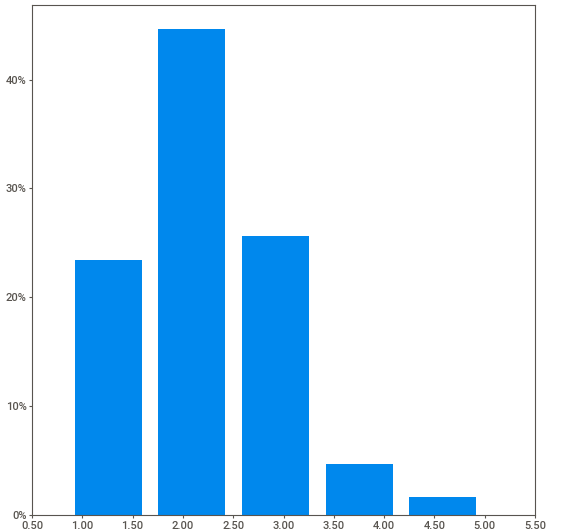
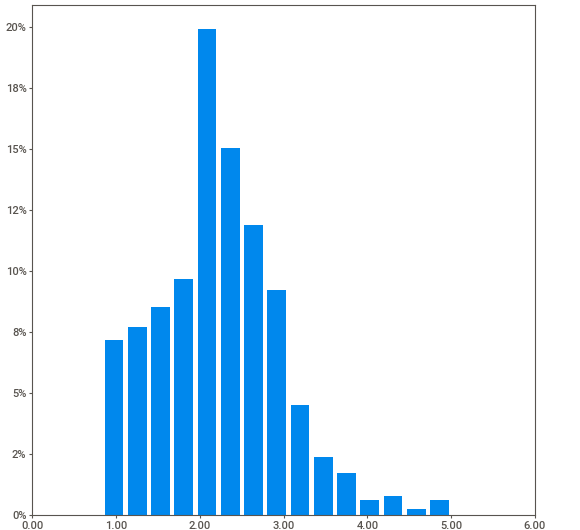
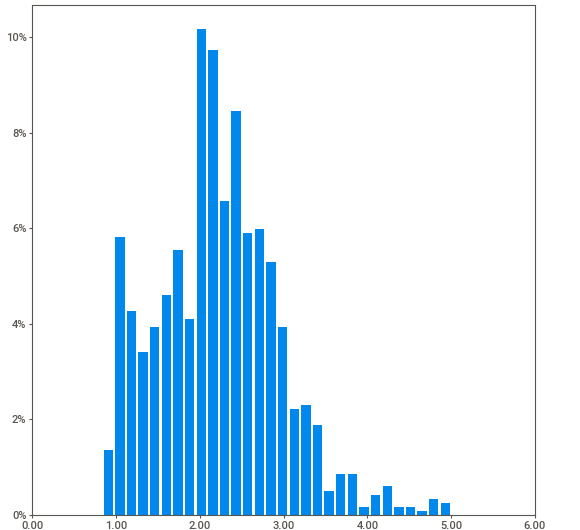
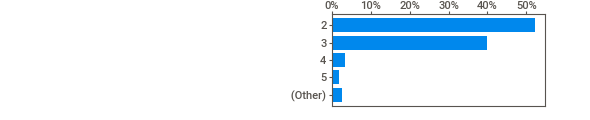
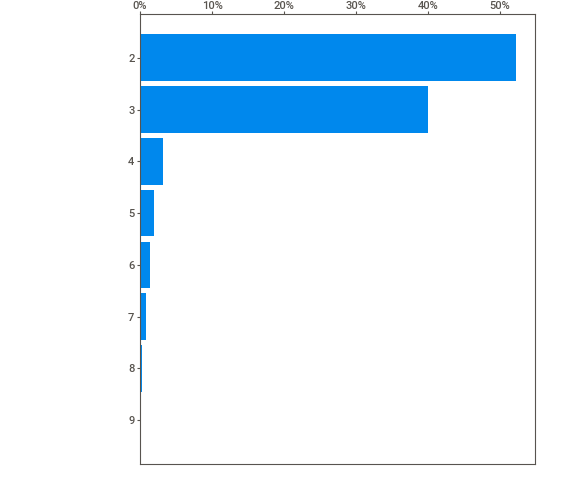
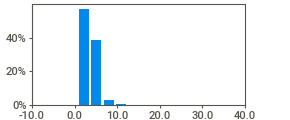
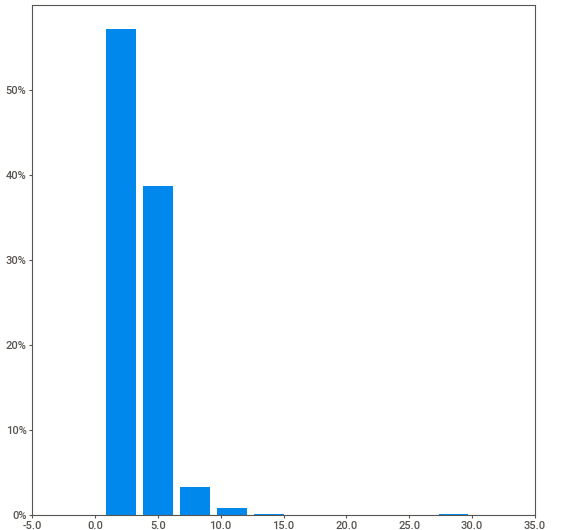
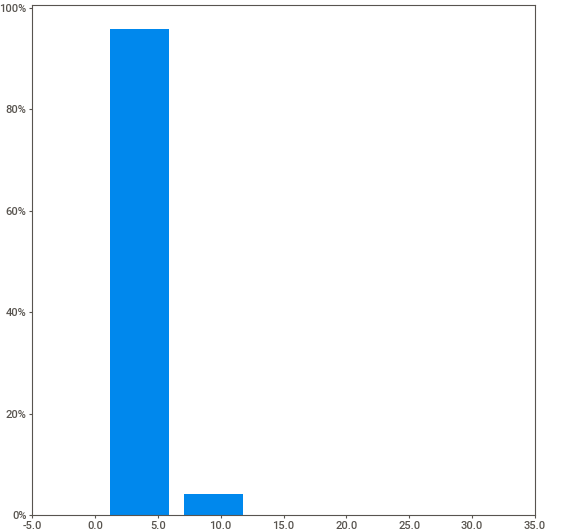
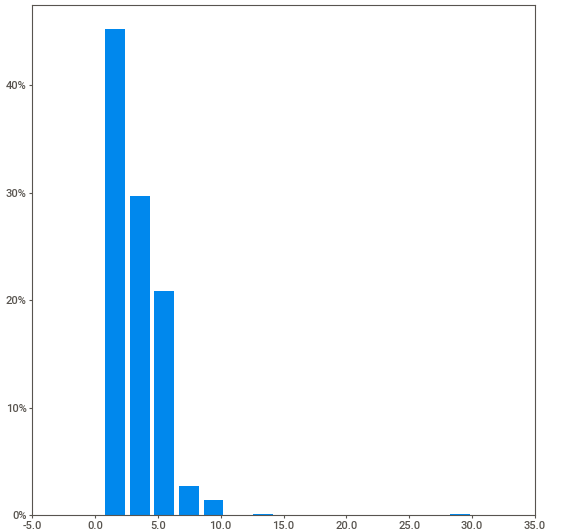
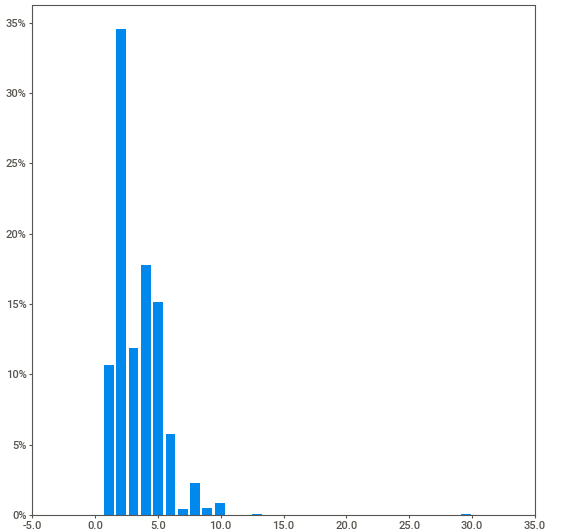
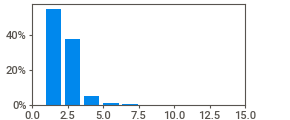
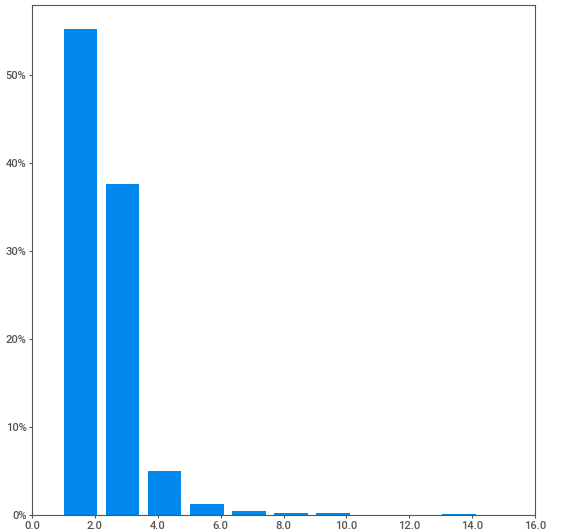
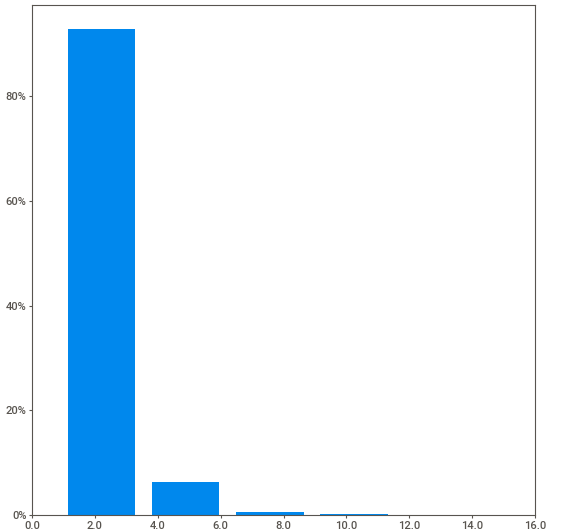
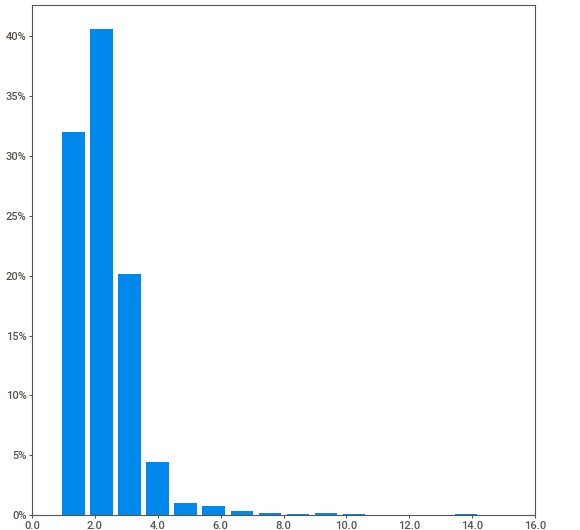
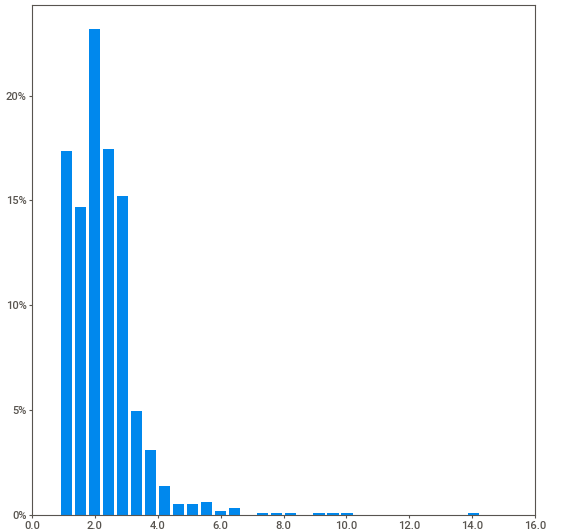
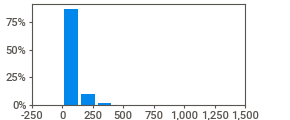
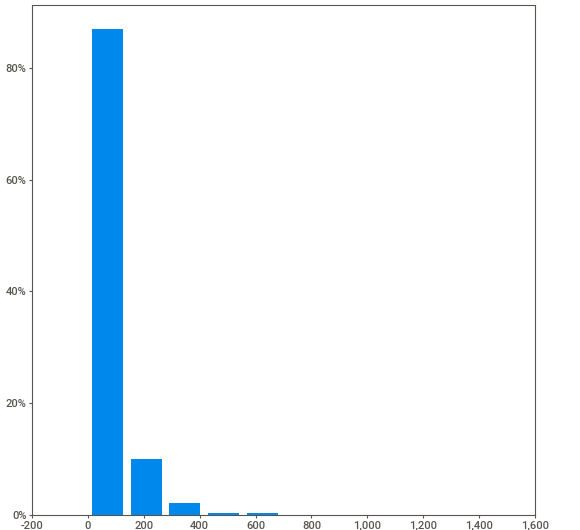
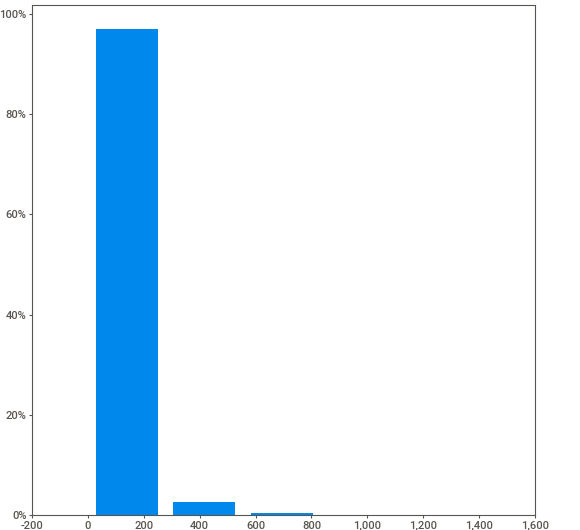
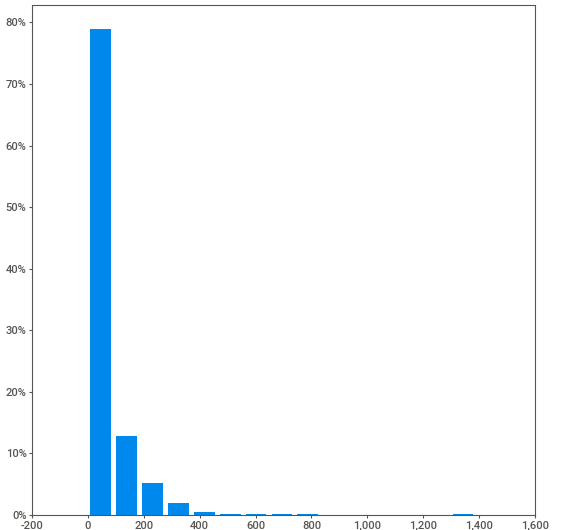
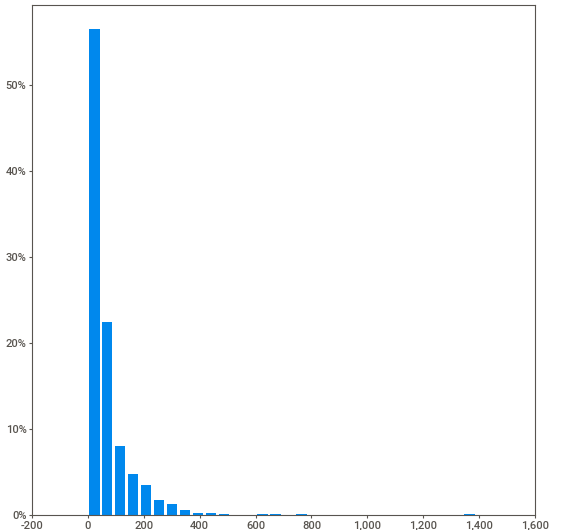
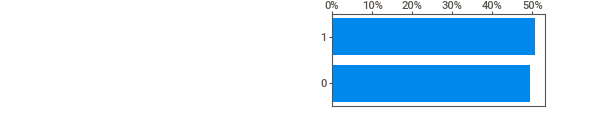
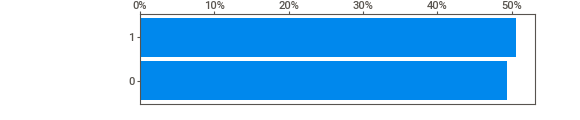
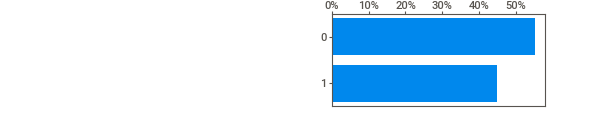
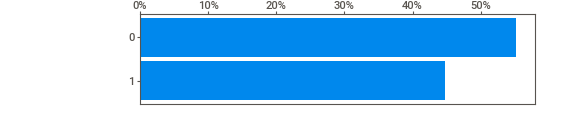
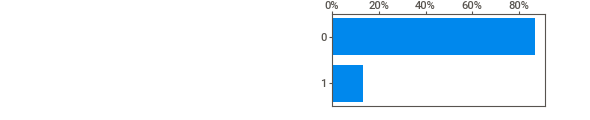
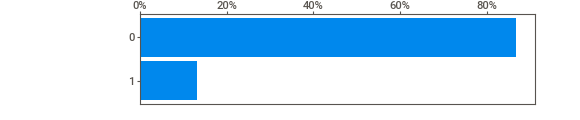
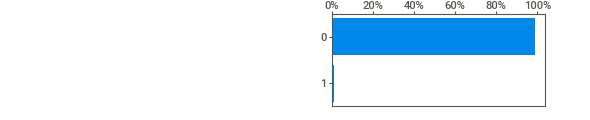
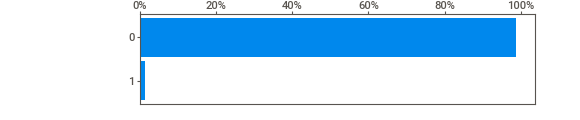
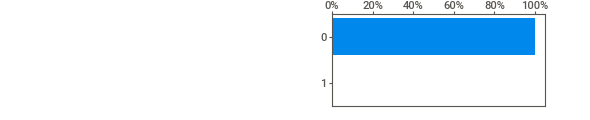
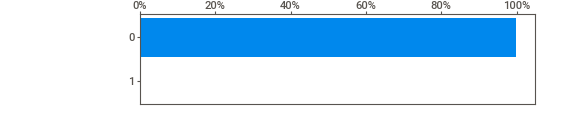
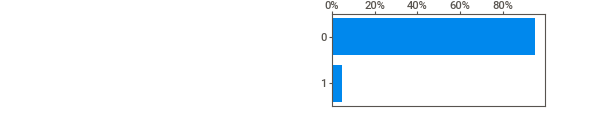
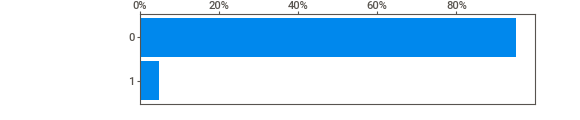
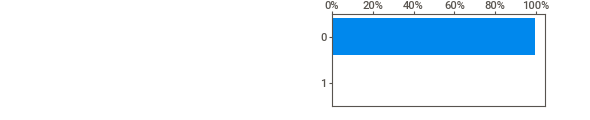
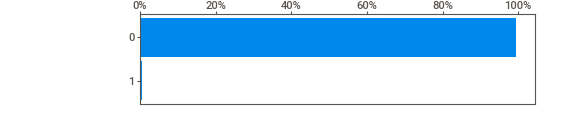
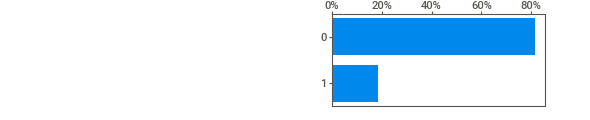
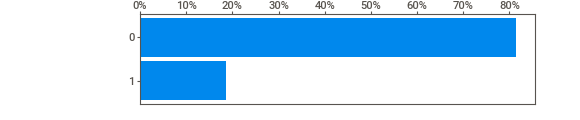
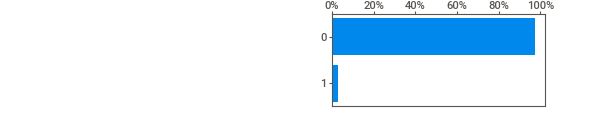
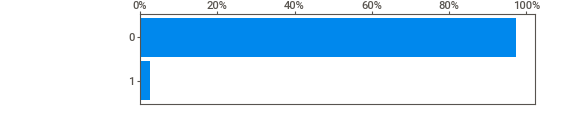
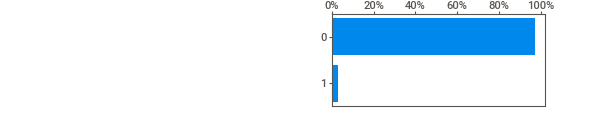
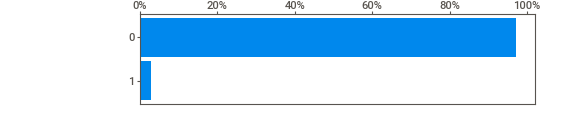
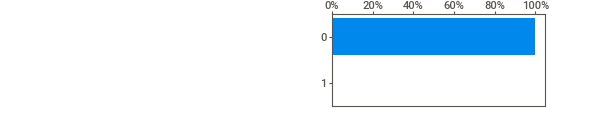
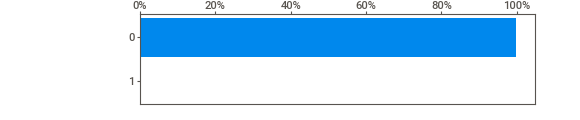
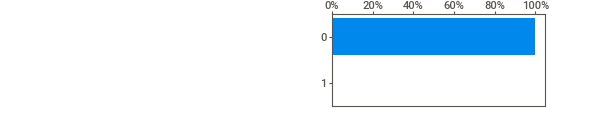
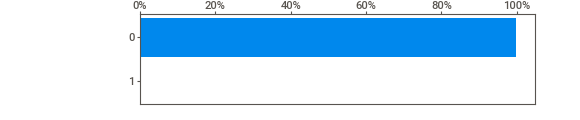
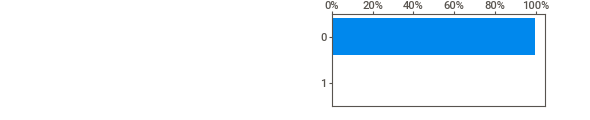
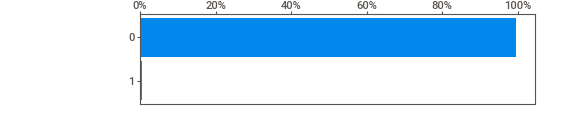
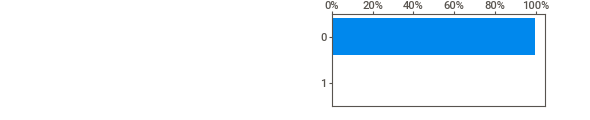
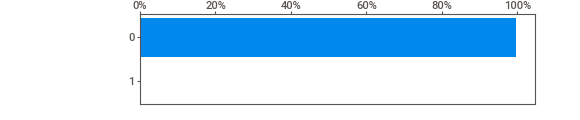
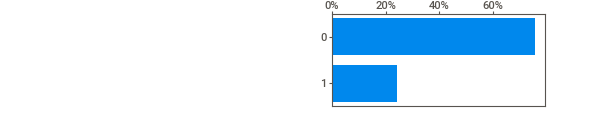
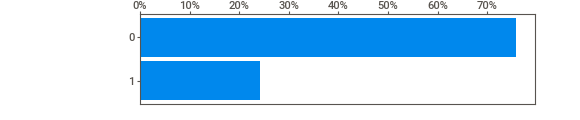
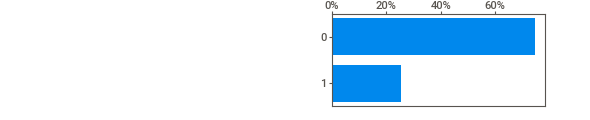
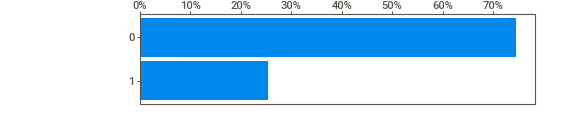
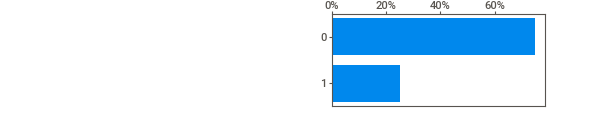
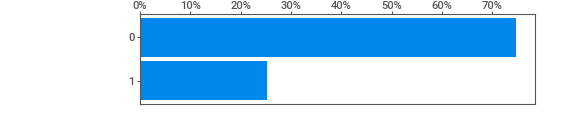
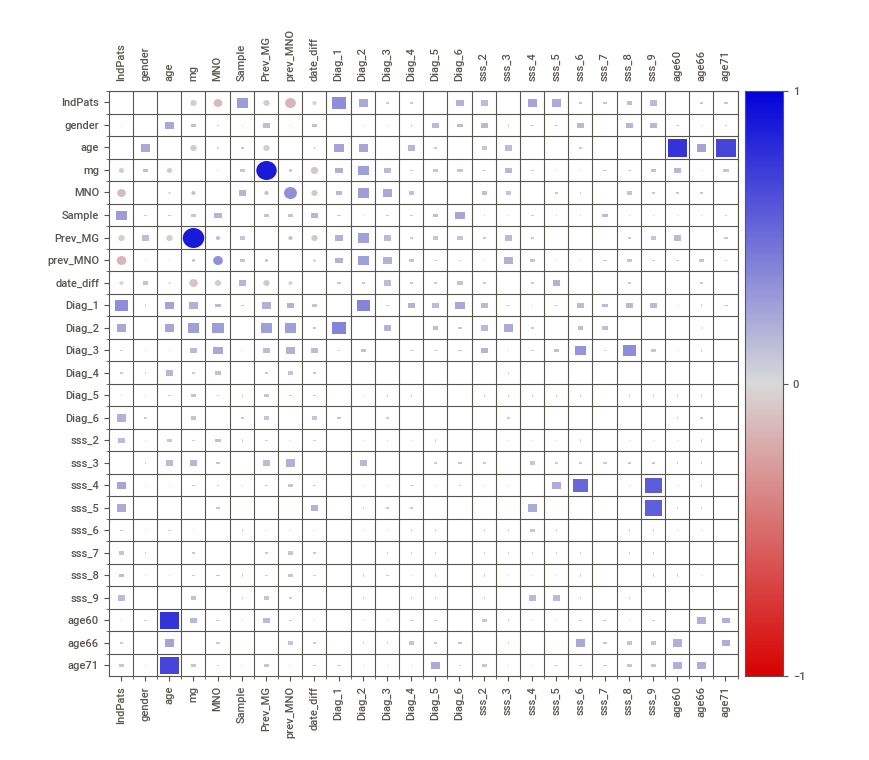
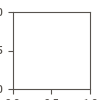

In [37]:
#@title Интерпретируем результат
ar = sw.analyze(df)
ar.show_notebook()

In [38]:
from sklearn.ensemble import IsolationForest
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split

from scipy import stats

# Формируем 2 Датасета df1 x_test1 y_test1 - там где у нас нет предистории
# и df x_test,y_test там где есть

#df.dropna(inplace=True)
df = pd.read_excel(os.path.join(PATH,fname[:-5]+'_dif.xlsx'))

df1 = df[df['Sample'] == 1]
df1 = df1.drop(columns=[ 'Prev_MG','prev_MNO','date_diff'])

df1.dropna(inplace=True)  # убираем пустые значения
print (f'Sample1:{df1.shape[0]}, Sample2-8:{df.shape[0]}')

df.dropna(inplace=True)   # убираем пустые значения
# Формируем тренировочную и тестовые выборки
train,test = train_test_split(df,test_size=0.2, random_state=33)
train1,test1 = train_test_split(df1,test_size=0.2, random_state=33)

names = df.columns.tolist() # список имен колонок
names1 = df1.columns.tolist()
names.remove('IndPats')
names1.remove('IndPats')
names1.remove('Sample')
names.remove('age') # Возраст есть в 3х подкатегориях поэтому убираем
names.remove('mg')  # Это целевой столбец
names1.remove('age') # Возраст есть в 3х подкатегориях поэтому убираем
names1.remove('mg')  # Это целевой столбец
print(names)
print(names1)
x_train = train[names].to_numpy()
y_train = train['mg'].to_numpy()
x_test = test[names].to_numpy()
y_test = test['mg'].to_numpy().astype('float')
x_train1 = train1[names1].to_numpy()
y_train1 = train1['mg'].to_numpy()
x_test1 = test1[names1].to_numpy()
y_test1 = test1['mg'].to_numpy().astype('float')
print('Sampl1',x_train1.shape,y_train1.shape,x_test1.shape,y_test1.shape)
print('Sample2-8',x_train.shape,y_train.shape,x_test.shape,y_test.shape)

#x_train = X_train
#y_train = Y_train

Sample1:689, Sample2-8:1859
['gender', 'MNO', 'Sample', 'Prev_MG', 'prev_MNO', 'date_diff', 'Diag_1', 'Diag_2', 'Diag_3', 'Diag_4', 'Diag_5', 'Diag_6', 'sss_2', 'sss_3', 'sss_4', 'sss_5', 'sss_6', 'sss_7', 'sss_8', 'sss_9', 'age60', 'age66', 'age71']
['gender', 'MNO', 'Diag_1', 'Diag_2', 'Diag_3', 'Diag_4', 'Diag_5', 'Diag_6', 'sss_2', 'sss_3', 'sss_4', 'sss_5', 'sss_6', 'sss_7', 'sss_8', 'sss_9', 'age60', 'age66', 'age71']
Sampl1 (551, 19) (551,) (138, 19) (138,)
Sample2-8 (936, 23) (936,) (234, 23) (234,)


In [11]:
%pdb on

Automatic pdb calling has been turned ON


In [ ]:
#@title Пробуем аугментацию
if False:'''
#import smogn
from SMOGN import smogn

#print(train.columns)
print(train.shape)
#print(train.info())
#train.drop(columns = 'AnalisDate',inplace=True)
#print(train.columns)
#smogn.box_plot_stats(train['MNO'])['stats']
#train.reset_index(inplace=True)
sm = smogn.SMOGN(threshold=0.9, over_sampling_ratio = 0.05,relevanse_base=0.5)
train_smogn = sm.fit_transform(train1,'mg')
'''

In [41]:
#@title Базовая модель
from IPython.display import HTML

# Display the plotly visualization in the notebook
#HTML(filename='catboost_info/learn.html')

from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
K = 5
kf = KFold(n_splits = K, random_state = 1, shuffle = True) # используем кросс-валидацию
cat = CatBoostRegressor()
cat1 = CatBoostRegressor()
cat.fit(x_train,y_train,verbose=False, plot=False)
cat1.fit(x_train1,y_train1,verbose=False, plot=False)
from catboost import Pool, cv
params = {"iterations": 3000,
          "depth": 2,
          "loss_function": "MAPE",
          "boosting_type" : 'Ordered',
          "verbose": False}
cv_dataset = Pool(data=x_train,
                  label=y_train)
cv1_dataset = Pool(data=x_train1,
                  label=y_train1)




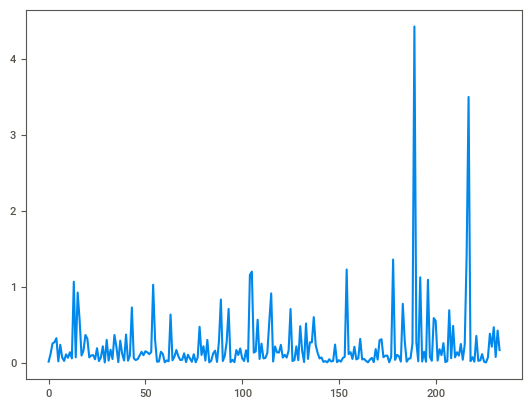

Средний показатель mg:3.5633199471377583, MAPE = 8.912306311948603 МАЕ = 0.2259254905168727 R2 = 0.9335643308926191
Процент значений >0.5мг [11.53846154]%
MAE quantile 90% 0.5577562325632356


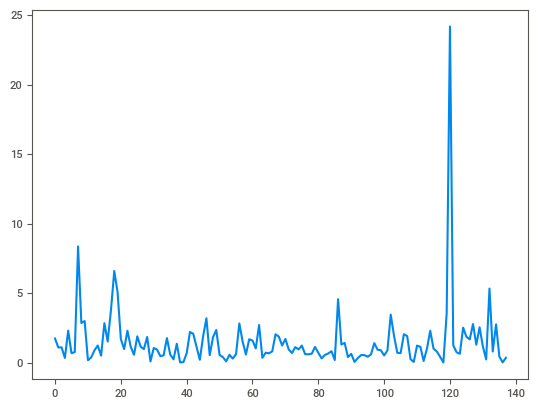

Средний показатель mg1:3.5633199471377583, MAPE = 73.9519104384801 МАЕ = 1.4789730366333094 R2 = -1.6181418168078174
Процент значений >0.5мг [79.71014493]%
MAE quantile 90% 2.787935990420081


In [60]:
mape =[]
mae =[]
y_pred = cat.predict(x_test)
for i in range(y_test.shape[0]):
  mae1 = abs(y_test[i]-y_pred[i])
  m = mae1 /y_test[i]
  mape.append(m)
  mae.append(mae1)
mape = np.asarray(mape)
mae = np.asarray(mae)
r2=r2_score(y_test,y_pred)
plt.plot(mae, label = 'MAE')
plt.show()
print(f'Средний показатель mg:{y_pred.mean()}, MAPE = {mape.mean()*100} МАЕ = {mae.mean()} R2 = {r2}')
print(f'Процент значений >0.5мг {(mae > 0.5).sum()/mae.shape*100}%')
print(f'MAE quantile 90% {np.quantile(mae,0.9)}')
mape =[]
mae =[]
y_pred1 = cat1.predict(x_test1)
for i in range(y_test1.shape[0]):
  mae1 = abs(y_test1[i]-y_pred1[i])
  m = mae1 /y_test1[i]
  mape.append(m)
  mae.append(mae1)
mape = np.asarray(mape)
mae = np.asarray(mae)
plt.plot(mae, label = 'MAE 1')
plt.show()
r2=r2_score(y_test1,y_pred1)
print(f'Средний показатель mg1:{y_pred.mean()}, MAPE = {mape.mean()*100} МАЕ = {mae.mean()} R2 = {r2}')
print(f'Процент значений >0.5мг {(mae > 0.5).sum()/mae.shape*100}%')
print(f'MAE quantile 90% {np.quantile(mae,0.9)}')


Базовая модедь неплохо отрабатывает там: гдеу нас есть данные предыдущих замеров МНО и неудовлетворительно на первичном назначенииБ так как там очень мало данных

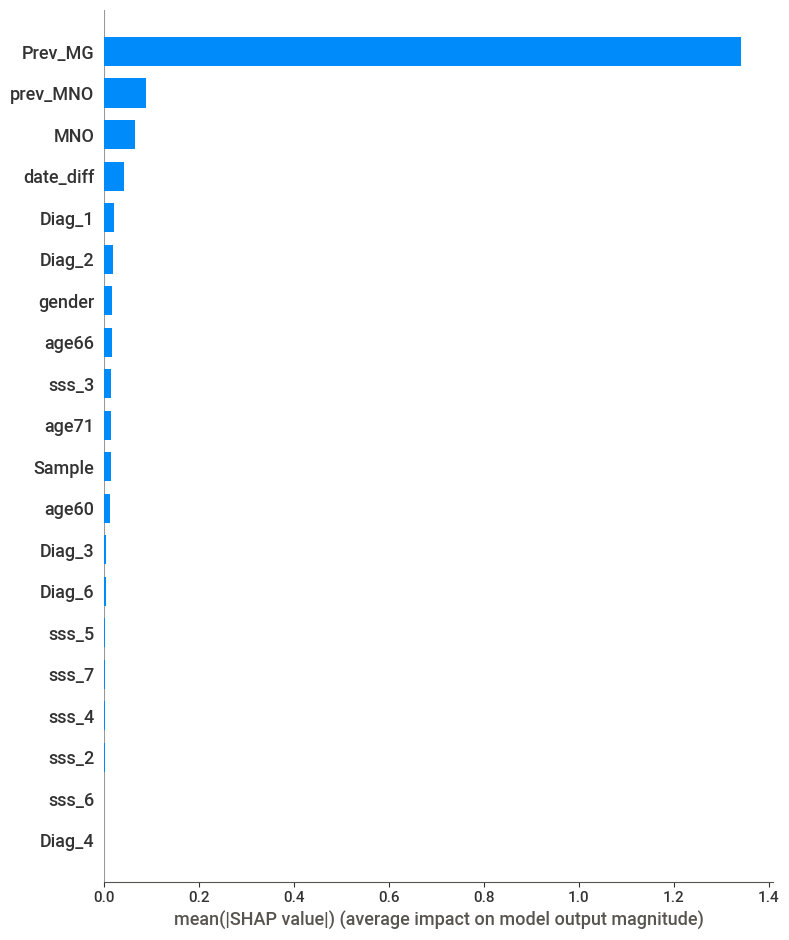

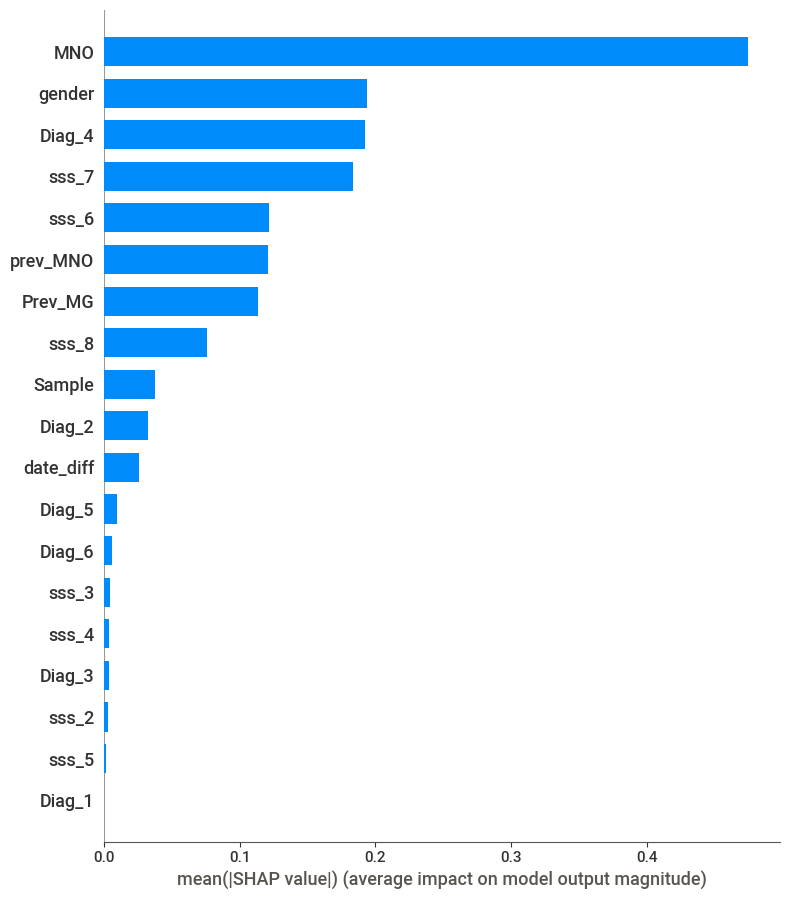

In [31]:
#@title Объяснялки
explainer = shap.Explainer(cat)
shap_values = explainer(x_test)
#shap.plots.waterfall(shap_values[0])
shap.summary_plot(shap_values, plot_type = 'bar', feature_names = names)
explainer1 = shap.Explainer(cat1)
shap_values = explainer1(x_test1)
#shap.plots.waterfall(shap_values[0])
shap.summary_plot(shap_values, plot_type = 'bar', feature_names = names)

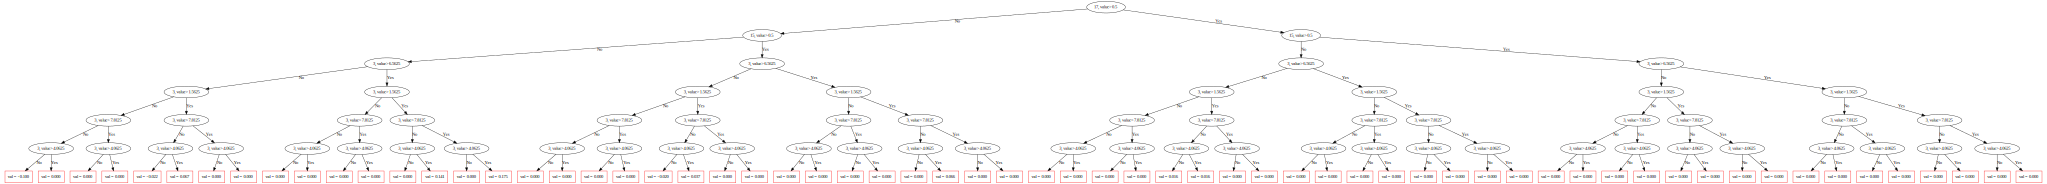

In [61]:
cat.plot_tree(tree_idx=0)

In [62]:
#@title TPOT (фреймворк AUTOML)
from tpot import TPOTRegressor
tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42)
tpot.fit(x_train, y_train)
print(tpot.score(x_test, y_test))
tpot.export('tpot_warfarin_pipeline.py')
tpot1 = TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42)
tpot1.fit(x_train1, y_train1)
print(tpot1.score(x_test1, y_test1))
tpot1.export('tpot_warfarin_1_pipeline.py')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.2136028198117054

Generation 2 - Current best internal CV score: -0.21310263814383218

Generation 3 - Current best internal CV score: -0.21310263814383218

Generation 4 - Current best internal CV score: -0.21310263814383218

Generation 5 - Current best internal CV score: -0.20892108577460383

Best pipeline: DecisionTreeRegressor(input_matrix, max_depth=6, min_samples_leaf=9, min_samples_split=19)
-0.2458811483545676


Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -4.044566697065804

Generation 2 - Current best internal CV score: -4.044566697065804

Generation 3 - Current best internal CV score: -4.040419755417089

Generation 4 - Current best internal CV score: -4.040419755417089

Generation 5 - Current best internal CV score: -4.024489915598675

Best pipeline: KNeighborsRegressor(RidgeCV(input_matrix), n_neighbors=95, p=1, weights=uniform)
-2.5189583207876667


В результате работы модели формируется Python файл, из которго в Ноутбуке я использую только настроенный регрессор

Средний показатель Мг:3.531891855882344, MAPE = 6.981934256447107 МАЕ = 0.20715707310501377 R2 = 0.9332292663383874
Процент значений >0.5мг [12.39316239]%
MAE quantile 90% 0.6129032258064523


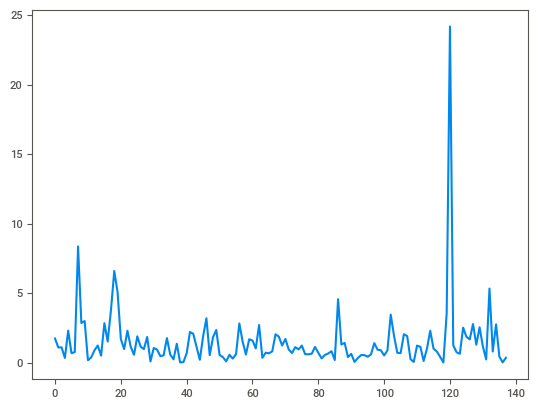

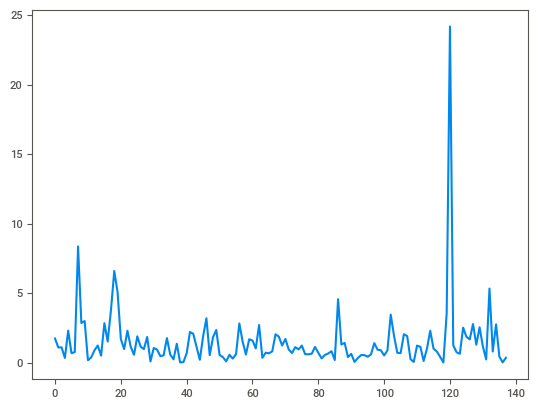

Средний показатель Мг1:3.5109192918442496, MAPE = 73.9519104384801 МАЕ = 1.4789730366333094 R2 = -1.6181418168078174
Процент значений >0.5мг [79.71014493]%
MAE quantile 90% 2.787935990420081


In [64]:
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import FastICA
from sklearn.linear_model import LassoLarsCV
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

training_features, testing_features, training_target, testing_target = \
  x_train,x_test,y_train,y_test
training_features1, testing_features1, training_target1, testing_target1 = \
  x_train1,x_test1,y_train1,y_test1

# Average CV score on the training set was: -0.1886107689462097
#exported_pipeline = RandomForestRegressor(bootstrap=False, max_features=0.8500000000000001, min_samples_leaf=7, min_samples_split=7, n_estimators=100)
#exported_pipeline = RandomForestRegressor(bootstrap=True, max_features=0.7500000000000001, min_samples_leaf=4, min_samples_split=9, n_estimators=100)
#exported_pipeline = RandomForestRegressor(bootstrap=False, max_features=0.7500000000000001, min_samples_leaf=2, min_samples_split=2, n_estimators=100)
exported_pipeline = DecisionTreeRegressor(max_depth=6, min_samples_leaf=9, min_samples_split=19)
# Fix random state in exported estimator
if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', 42)
# Fix random state in exported estimator
if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', 42)

exported_pipeline.fit(training_features, training_target)
y_pred = exported_pipeline.predict(testing_features)
mape =[]
mae =[]
#r2 = []
for i in range(y_test.shape[0]):
  mae1 = abs(y_test[i]-y_pred[i])
  m = mae1 /y_test[i]
  mape.append(m)
  mae.append(mae1)
  r2=r2_score(y_test,y_pred)
mape = np.asarray(mape)
mae = np.asarray(mae)
#r2 = np.asarray(r2)
print(f'Средний показатель Мг:{y_pred.mean()}, MAPE = {mape.mean()*100} МАЕ = {mae.mean()} R2 = {r2}')
print(f'Процент значений >0.5мг {(mae > 0.5).sum()/mae.shape*100}%')
print(f'MAE quantile 90% {np.quantile(mae,0.9)}')
#exported_pipeline1 =  make_pipeline(StandardScaler(),KNeighborsRegressor(n_neighbors=55, p=2, weights="uniform"))
exported_pipeline1 = make_pipeline(StackingEstimator(estimator=RidgeCV()),KNeighborsRegressor(n_neighbors=95, p=1, weights="uniform"))

# Fix random state in exported estimator
if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', 42)

exported_pipeline.fit(training_features1, training_target1)
y_pred = exported_pipeline.predict(testing_features1)
mape =[]
mae =[]
#r2 = []
for i in range(y_test1.shape[0]):
  mae1 = abs(y_test1[i]-y_pred1[i])
  m = mae1 /y_test1[i]
  mape.append(m)
  mae.append(mae1)
  r2=r2_score(y_test1,y_pred1)
plt.plot(mae, label = 'MAE')
plt.show()
mape = np.asarray(mape)
mae = np.asarray(mae)
r2 = np.asarray(r2)
plt.plot(mae, label = 'MAE 1')
plt.show()
print(f'Средний показатель Мг1:{y_pred.mean()}, MAPE = {mape.mean()*100} МАЕ = {mae.mean()} R2 = {r2}')
print(f'Процент значений >0.5мг {(mae > 0.5).sum()/mae.shape*100}%')
print(f'MAE quantile 90% {np.quantile(mae,0.9)}')


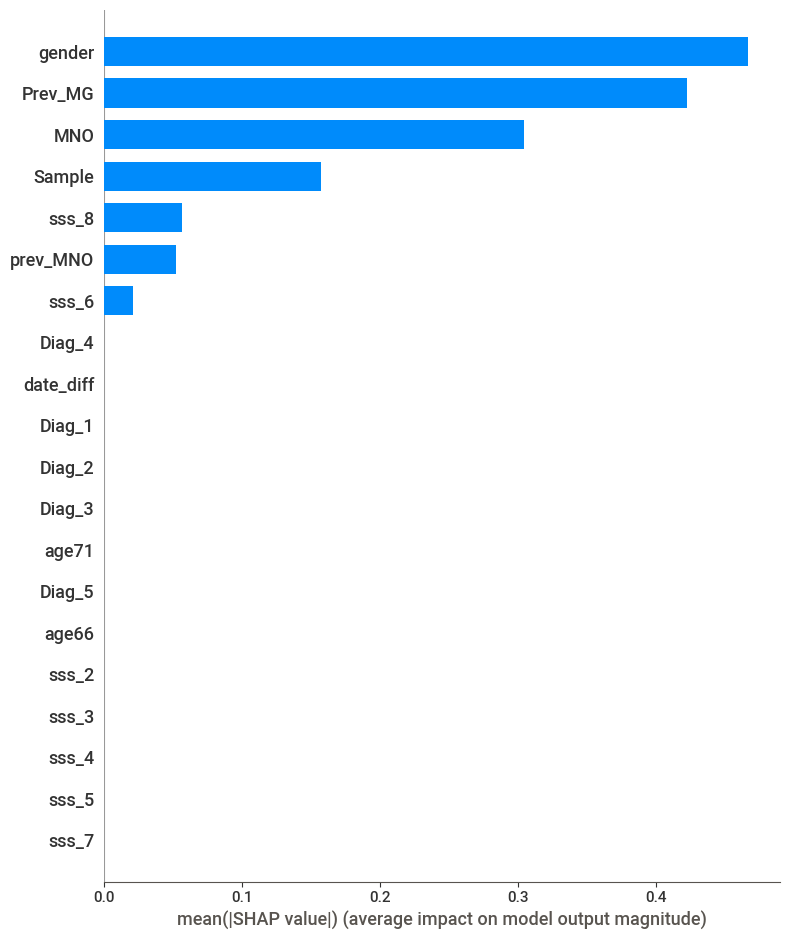

In [65]:
#@title Объяснялки
explainer = shap.Explainer(exported_pipeline)
shap_values = explainer(x_test)
#shap.plots.waterfall(shap_values[0])
shap.summary_plot(shap_values, plot_type = 'bar', feature_names = names)


In [66]:
#@title AUTOML
from flaml import AutoML
# Initialize an AutoML instance
automl = AutoML()
# Specify automl goal and constraint
automl_settings = {
    "time_budget": 1,  # in seconds
    "metric": 'r2',
    "task": 'regression',
    "log_file_name": "warfarin.log",
}
# Train with labeled input data
automl.fit(X_train=x_train, y_train=y_train,
           **automl_settings)
# Print the best model
print(automl.model.estimator)

[flaml.automl.logger: 08-25 12:51:52] {1679} INFO - task = regression
[flaml.automl.logger: 08-25 12:51:52] {1690} INFO - Evaluation method: holdout
[flaml.automl.logger: 08-25 12:51:52] {1788} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 08-25 12:51:52] {1900} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl.logger: 08-25 12:51:52] {2218} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 08-25 12:51:52] {2344} INFO - Estimated sufficient time budget=277s. Estimated necessary time budget=2s.
[flaml.automl.logger: 08-25 12:51:52] {2391} INFO -  at 0.1s,	estimator lgbm's best error=0.5394,	best estimator lgbm's best error=0.5394
[flaml.automl.logger: 08-25 12:51:52] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 08-25 12:51:52] {2391} INFO -  at 0.1s,	estimator lgbm's best error=0.5394,	best estimator lgbm's best error=0.5394
[flaml.automl.logger: 08-25 12:51:52]

In [68]:
mape =[]
mae =[]
y_pred = automl.predict(x_test)
for i in range(y_test.shape[0]):
  mae1 = abs(y_test[i]-y_pred[i])
  m = mae1 /y_test[i]
  mape.append(m)
  mae.append(mae1)
mape = np.asarray(mape)
mae = np.asarray(mae)
r2=r2_score(y_test,y_pred)
print(f'Средний показатель МНО:{y_pred.mean()}, MAPE = {mape.mean()*100} МАЕ = {mae.mean()} R2 = {r2}')
print(f'Процент значений >0.5мг {(mae > 0.5).sum()/mae.shape*100}%')
print(f'MAE quantile 90% {np.quantile(mae,0.9)}')


Средний показатель МНО:3.555197187685831, MAPE = 7.9237259713297385 МАЕ = 0.22537249356312958 R2 = 0.9338367725076571
Процент значений >0.5мг [10.68376068]%
MAE quantile 90% 0.5346587783900467
